In [1]:
import numpy as np
import cv2
#from vidstab import VidStab
from os import listdir
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()
import skimage 
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from progressbar import ProgressBar

In [28]:
### Helper Methods 



def last_4chars(x):
    suf = x.split("_")[1]
    inte = int(suf.split(".")[0])
    return inte

def getFrame(sec,path,stable_vid_name,count):
    vidcap = cv2.VideoCapture(stable_vid_name)
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite(path+"/image_"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames

    
def list_files1(directory, extension):
    """
    list_files1: Find files with a certain extension in the directory and return the names in a list
            Args:
                directory: Directory to be searched
                extension: the extension of the files
            Returns:
                List of files with the extension within the directory
    """
    return list(( (directory + f) for f in listdir(directory) if f.endswith('.' + extension)))

def generate_frames_vid():
    """
    generate_frames_vid: Generates frames for every video in listvideos, and save them in folder with
                         name vidName/
                    Args:
                        listvideos: List containing the path to the video files
                    Returns:
                        None
    """
    try:
        os.mkdir("StableFrames", 755)
    except OSError:
        pass
    try:
        os.mkdir("StableFrames/videos", 755)
    except OSError:
        pass
    listvideos = list_files1('videos/','avi')
    for video in listvideos:
        path = "StableFrames/" + video.split('.avi')[0]
        try:
            os.mkdir(path, 755)
        except OSError:
            pass
        stable_vid_name = 'stable_video.avi'
        stabilizer = VidStab(kp_method='GFTT')
        stabilizer.stabilize(input_path=video, output_path=stable_vid_name)
        sec = 0
        frameRate = 0.5 #//it will capture image in each 0.5 second
        count=1
        success = getFrame(sec,path,stable_vid_name,count)
        while success:
            count = count + 1
            sec = sec + frameRate
            sec = round(sec, 2)
            success = getFrame(sec,path,stable_vid_name,count)
 
### Generate train_test data
def generate_train_testdata(k):
    """
    generate_train_testdata: Generate table for path to input and output data
                        Args:
                            k: Distance for the next frame
                        Returns:
                             df containg the input path and the corresponding output predicted
    """
    data = pd.DataFrame(columns=["input", "output"])
    directory = "StableFrames/videos"
    subdir = listdir(directory)
    for subd in subdir:
        images = sorted(listdir(directory + "/" + subdir[0]), key=last_4chars)
        for idx, img in enumerate(images):
            base_path = directory + "/" + subd + "/"
            input_img = base_path + img
            output_img = base_path + "image_" + str(idx+k+1) + ".jpg"
            if os.path.isfile(output_img):
                temp_df = pd.DataFrame([[input_img,output_img]], columns=["input", "output"])
                data =  pd.concat((data,temp_df))
    return data     

def read_from_path(X):
    """
    read_from_path: Read images from path, preprocess, and append to numpy data frame.
                Args:
                    X: List containing all the paths
                Returns:
                    data: numpy array containing all of the data
    """
    img_size = 128
    data = np.empty(shape = [1,img_size,img_size])
    pbar = ProgressBar()
    print("Starting Reading and Preprocessing.\n")
    for i in pbar(X):
        img = cv2.imread(i, 0)
        #img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img = preprocess_image(img)
        img = cv2.resize(img, (img_size,img_size))
        img = img.reshape(1,img_size,img_size)
        data = np.append(data,img, axis = 0)
    print("Done Reading and Preprocessing.\n")
    data = data.reshape(len(X)+1,img_size,img_size,1)
    return data

def get_best_circle(img1):
    """
    get_best_circle: Use hough transform to find the best circle
                Args: 
                     img1: Grayscale image on which to find the circle
                Returns:
                    circle: list containing the x-coords, y-coords of the center
                            and radius for the circle. 
    """
    edges = canny(img1, sigma=2, low_threshold=10, high_threshold=50)
    hough_radii = np.arange(50, 150, 2)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=3)
    max_idx = np.argmax(radii)
    max_x = cx[max_idx]
    max_y = cy[max_idx]
    max_radii = radii[max_idx]
    return ([max_x, max_y, max_radii])

def preprocess_image(img1):
    """
    preprocess_image: Find the relevant information, and shift to the center
    
                Args:
                    img1: Image on which to perform the preprocessing
                Returns:
                    masked_img: Image with preprocessing done
    
    """
    x_coord, y_coord, radius = get_best_circle(img1)
    
    height,width = img1.shape
    mask = np.zeros((height,width), np.uint8) 
    x,y = skimage.draw.circle(y_coord,x_coord,radius)
    mask[x,y] = 1
    masked_data = mask*img1
    
    M = np.float32([[1,0,250-x_coord],[0,1,250-y_coord]])
    masked_img = cv2.warpAffine(masked_data,M,(height,width))
    return masked_img
    




        



In [29]:
#generate_frames_vid()
train_test_data = generate_train_testdata(1)  

In [ ]:
inp = train_test_data.iloc[:,0].values.tolist()
inp_d = read_from_path(inp)
out = train_test_data.iloc[:,1].values.tolist()
out_d = read_from_path(out)


In [59]:
def encoder_decoder(img_size):
    model = tf.keras.Sequential()
    ###Encoder
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 6,strides=2, padding = "valid",
                                     activation = "relu", input_shape = (img_size,img_size,1),
                                     kernel_initializer = tf.keras.initializers.glorot_normal(seed=15),
                                     name= "layer1"))
    model.add(tf.keras.layers.MaxPool2D(3, strides=2, padding="valid", name = "pool1"))
    model.add(tf.keras.layers.Conv2D(filters =  12, kernel_size = 6,strides=2, padding = "valid",
                                     activation = "relu",
                                     kernel_initializer = tf.keras.initializers.glorot_normal(seed=15),
                                     name= "layer2"))
    model.add(tf.keras.layers.MaxPool2D(3, strides=2, padding="valid", name = "pool2"))
    
    model.add(tf.keras.layers.Reshape((1,432)))
    model.add(tf.keras.layers.Dense(2, activation = "sigmoid", 
                                    kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)))
    model.add(tf.keras.layers.Dense(16384, activation = "relu",
                                    kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)))
    model.add(tf.keras.layers.Reshape((img_size,img_size,1)))
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mean_squared_error',
              metrics=['mae'])

    return model

In [60]:
encoder = encoder_decoder(128)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv2D)              (None, 62, 62, 64)        2368      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 30, 30, 64)        0         
_________________________________________________________________
layer2 (Conv2D)              (None, 13, 13, 12)        27660     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 6, 6, 12)          0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 1, 432)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 1, 2)              866       
_________________________________________________________________
dense_11 (Dense)             (None, 1, 16384)         

In [61]:
batch_size = 32
epochs = 10000
validation_split = 0.1
encoder.fit(x = inp_d, y = out_d, batch_size = batch_size, epochs=epochs,
            validation_split=validation_split, verbose=1)

Train on 36 samples, validate on 4 samples
Epoch 1/10000
36/36 [==============================] - 0s 12ms/sample - loss: 1832.3382 - mae: 16.7626 - val_loss: 2291.4043 - val_mae: 21.6990
Epoch 2/10000
36/36 [==============================] - 0s 7ms/sample - loss: 1830.9102 - mae: 16.7554 - val_loss: 2289.6697 - val_mae: 21.6886
Epoch 3/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1829.5347 - mae: 16.7495 - val_loss: 2287.8584 - val_mae: 21.6786
Epoch 4/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1828.1037 - mae: 16.7442 - val_loss: 2286.0166 - val_mae: 21.6685
Epoch 5/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1826.6549 - mae: 16.7388 - val_loss: 2284.1567 - val_mae: 21.6582
Epoch 6/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1825.1946 - mae: 16.7334 - val_loss: 2282.2891 - val_mae: 21.6480
Epoch 7/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1823.7512 - mae: 16.7

36/36 [==============================] - 0s 8ms/sample - loss: 1754.1472 - mae: 16.4588 - val_loss: 2191.5947 - val_mae: 21.1375
Epoch 58/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1752.7753 - mae: 16.4520 - val_loss: 2189.8494 - val_mae: 21.1276
Epoch 59/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1751.4231 - mae: 16.4432 - val_loss: 2188.1143 - val_mae: 21.1177
Epoch 60/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1750.0582 - mae: 16.4377 - val_loss: 2186.3838 - val_mae: 21.1078
Epoch 61/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1748.7511 - mae: 16.4327 - val_loss: 2184.6782 - val_mae: 21.0981
Epoch 62/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1747.3884 - mae: 16.4269 - val_loss: 2183.0017 - val_mae: 21.0884
Epoch 63/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1746.0672 - mae: 16.4215 - val_loss: 2181.2964 - val_mae: 21.0787
Epoch 6

Epoch 114/10000
36/36 [==============================] - 0s 7ms/sample - loss: 1679.8424 - mae: 16.1440 - val_loss: 2095.9688 - val_mae: 20.5817
Epoch 115/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1678.5625 - mae: 16.1383 - val_loss: 2094.3818 - val_mae: 20.5723
Epoch 116/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1677.3165 - mae: 16.1329 - val_loss: 2092.7817 - val_mae: 20.5628
Epoch 117/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1676.0742 - mae: 16.1276 - val_loss: 2091.1697 - val_mae: 20.5532
Epoch 118/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1674.8071 - mae: 16.1219 - val_loss: 2089.5356 - val_mae: 20.5435
Epoch 119/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1673.5415 - mae: 16.1165 - val_loss: 2087.8774 - val_mae: 20.5336
Epoch 120/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1672.2754 - mae: 16.1111 - val_loss: 2086.2266 - va

36/36 [==============================] - 0s 5ms/sample - loss: 1612.2620 - mae: 15.8397 - val_loss: 2009.2241 - val_mae: 20.0558
Epoch 171/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1611.0510 - mae: 15.8341 - val_loss: 2007.7297 - val_mae: 20.0467
Epoch 172/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1609.9225 - mae: 15.8290 - val_loss: 2006.2603 - val_mae: 20.0376
Epoch 173/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1608.7624 - mae: 15.8235 - val_loss: 2004.8057 - val_mae: 20.0287
Epoch 174/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1607.6395 - mae: 15.8183 - val_loss: 2003.3345 - val_mae: 20.0196
Epoch 175/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1606.5136 - mae: 15.8131 - val_loss: 2001.8516 - val_mae: 20.0105
Epoch 176/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1605.3811 - mae: 15.8080 - val_loss: 2000.3689 - val_mae: 20.0014
E

36/36 [==============================] - 0s 5ms/sample - loss: 1548.7432 - mae: 15.5420 - val_loss: 1926.2982 - val_mae: 19.5385
Epoch 227/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1547.6012 - mae: 15.5366 - val_loss: 1924.7880 - val_mae: 19.5290
Epoch 228/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1546.4628 - mae: 15.5314 - val_loss: 1923.2653 - val_mae: 19.5194
Epoch 229/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1545.3118 - mae: 15.5260 - val_loss: 1921.7305 - val_mae: 19.5097
Epoch 230/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1544.1934 - mae: 15.5209 - val_loss: 1920.2163 - val_mae: 19.5002
Epoch 231/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1543.0574 - mae: 15.5156 - val_loss: 1918.7664 - val_mae: 19.4910
Epoch 232/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1541.9476 - mae: 15.5102 - val_loss: 1917.3660 - val_mae: 19.4820
E

36/36 [==============================] - 0s 5ms/sample - loss: 1489.4430 - mae: 15.2514 - val_loss: 1848.4706 - val_mae: 19.0359
Epoch 283/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1488.3980 - mae: 15.2461 - val_loss: 1847.1061 - val_mae: 19.0269
Epoch 284/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1487.3785 - mae: 15.2410 - val_loss: 1845.7310 - val_mae: 19.0179
Epoch 285/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1486.3383 - mae: 15.2357 - val_loss: 1844.3669 - val_mae: 19.0088
Epoch 286/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1485.3144 - mae: 15.2306 - val_loss: 1843.0200 - val_mae: 18.9999
Epoch 287/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1484.2817 - mae: 15.2252 - val_loss: 1841.6956 - val_mae: 18.9911
Epoch 288/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1483.2748 - mae: 15.2201 - val_loss: 1840.3860 - val_mae: 18.9824
E

36/36 [==============================] - 0s 6ms/sample - loss: 1434.4423 - mae: 14.9657 - val_loss: 1775.4526 - val_mae: 18.5463
Epoch 339/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1433.5253 - mae: 14.9610 - val_loss: 1774.1930 - val_mae: 18.5377
Epoch 340/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1432.5799 - mae: 14.9559 - val_loss: 1772.9510 - val_mae: 18.5293
Epoch 341/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1431.6552 - mae: 14.9511 - val_loss: 1771.7100 - val_mae: 18.5208
Epoch 342/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1430.7127 - mae: 14.9459 - val_loss: 1770.4587 - val_mae: 18.5123
Epoch 343/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1429.7881 - mae: 14.9410 - val_loss: 1769.1921 - val_mae: 18.5037
Epoch 344/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1428.8573 - mae: 14.9361 - val_loss: 1767.9403 - val_mae: 18.4952
E

36/36 [==============================] - 0s 5ms/sample - loss: 1383.2153 - mae: 14.6885 - val_loss: 1706.9598 - val_mae: 18.0711
Epoch 395/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1382.3170 - mae: 14.6837 - val_loss: 1705.7267 - val_mae: 18.0624
Epoch 396/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1381.3896 - mae: 14.6786 - val_loss: 1704.5020 - val_mae: 18.0538
Epoch 397/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1380.4793 - mae: 14.6736 - val_loss: 1703.2441 - val_mae: 18.0449
Epoch 398/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1379.6052 - mae: 14.6690 - val_loss: 1702.0020 - val_mae: 18.0361
Epoch 399/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1378.6915 - mae: 14.6640 - val_loss: 1700.8268 - val_mae: 18.0278
Epoch 400/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1377.8190 - mae: 14.6591 - val_loss: 1699.6941 - val_mae: 18.0197
E

36/36 [==============================] - 0s 6ms/sample - loss: 1335.8810 - mae: 14.4165 - val_loss: 1642.8889 - val_mae: 17.6084
Epoch 451/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1335.0521 - mae: 14.4113 - val_loss: 1641.8741 - val_mae: 17.6008
Epoch 452/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1334.2854 - mae: 14.4066 - val_loss: 1640.8423 - val_mae: 17.5931
Epoch 453/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1333.5069 - mae: 14.4018 - val_loss: 1639.7898 - val_mae: 17.5853
Epoch 454/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1332.7374 - mae: 14.3972 - val_loss: 1638.7341 - val_mae: 17.5774
Epoch 455/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1331.9529 - mae: 14.3924 - val_loss: 1637.7108 - val_mae: 17.5698
Epoch 456/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1331.1793 - mae: 14.3876 - val_loss: 1636.7185 - val_mae: 17.5624
E

36/36 [==============================] - 0s 5ms/sample - loss: 1292.4121 - mae: 14.1522 - val_loss: 1583.7935 - val_mae: 17.1643
Epoch 507/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1291.6929 - mae: 14.1477 - val_loss: 1582.7769 - val_mae: 17.1565
Epoch 508/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1290.9524 - mae: 14.1431 - val_loss: 1581.7487 - val_mae: 17.1487
Epoch 509/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1290.2071 - mae: 14.1385 - val_loss: 1580.6987 - val_mae: 17.1408
Epoch 510/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1289.4925 - mae: 14.1343 - val_loss: 1579.6621 - val_mae: 17.1329
Epoch 511/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1288.7494 - mae: 14.1297 - val_loss: 1578.6653 - val_mae: 17.1254
Epoch 512/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1288.0374 - mae: 14.1253 - val_loss: 1577.6946 - val_mae: 17.1179
E

36/36 [==============================] - 0s 5ms/sample - loss: 1252.2852 - mae: 13.8974 - val_loss: 1528.2881 - val_mae: 16.7321
Epoch 563/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1251.6117 - mae: 13.8929 - val_loss: 1527.3567 - val_mae: 16.7246
Epoch 564/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1250.9384 - mae: 13.8884 - val_loss: 1526.4578 - val_mae: 16.7175
Epoch 565/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1250.2760 - mae: 13.8840 - val_loss: 1525.5881 - val_mae: 16.7105
Epoch 566/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1249.6202 - mae: 13.8794 - val_loss: 1524.7156 - val_mae: 16.7034
Epoch 567/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1248.9806 - mae: 13.8751 - val_loss: 1523.8313 - val_mae: 16.6963
Epoch 568/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1248.3070 - mae: 13.8704 - val_loss: 1522.9332 - val_mae: 16.6890
E

36/36 [==============================] - 0s 6ms/sample - loss: 1215.0209 - mae: 13.6461 - val_loss: 1476.4413 - val_mae: 16.3116
Epoch 619/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1214.3754 - mae: 13.6418 - val_loss: 1475.4762 - val_mae: 16.3037
Epoch 620/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1213.7137 - mae: 13.6375 - val_loss: 1474.5190 - val_mae: 16.2959
Epoch 621/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1213.0677 - mae: 13.6333 - val_loss: 1473.5835 - val_mae: 16.2883
Epoch 622/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1212.4070 - mae: 13.6289 - val_loss: 1472.6565 - val_mae: 16.2808
Epoch 623/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1211.7630 - mae: 13.6247 - val_loss: 1471.7101 - val_mae: 16.2731
Epoch 624/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1211.1399 - mae: 13.6207 - val_loss: 1470.7842 - val_mae: 16.2655
E

36/36 [==============================] - 0s 5ms/sample - loss: 1179.9745 - mae: 13.4019 - val_loss: 1426.4697 - val_mae: 15.8925
Epoch 675/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1179.3678 - mae: 13.3975 - val_loss: 1425.5693 - val_mae: 15.8848
Epoch 676/10000
36/36 [==============================] - 0s 7ms/sample - loss: 1178.7502 - mae: 13.3931 - val_loss: 1424.6395 - val_mae: 15.8770
Epoch 677/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1178.1203 - mae: 13.3886 - val_loss: 1423.6854 - val_mae: 15.8689
Epoch 678/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1177.4965 - mae: 13.3843 - val_loss: 1422.7181 - val_mae: 15.8609
Epoch 679/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1176.8737 - mae: 13.3801 - val_loss: 1421.7777 - val_mae: 15.8530
Epoch 680/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1176.2338 - mae: 13.3756 - val_loss: 1420.8582 - val_mae: 15.8453
E

36/36 [==============================] - 0s 5ms/sample - loss: 1147.9760 - mae: 13.1667 - val_loss: 1379.7100 - val_mae: 15.4862
Epoch 731/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1147.4375 - mae: 13.1627 - val_loss: 1378.8959 - val_mae: 15.4790
Epoch 732/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1146.8996 - mae: 13.1588 - val_loss: 1378.1022 - val_mae: 15.4719
Epoch 733/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1146.3321 - mae: 13.1544 - val_loss: 1377.3083 - val_mae: 15.4649
Epoch 734/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1145.7886 - mae: 13.1504 - val_loss: 1376.4817 - val_mae: 15.4576
Epoch 735/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1145.2503 - mae: 13.1465 - val_loss: 1375.6587 - val_mae: 15.4503
Epoch 736/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1144.6879 - mae: 13.1423 - val_loss: 1374.8524 - val_mae: 15.4432
E

36/36 [==============================] - 0s 5ms/sample - loss: 1119.6724 - mae: 12.9430 - val_loss: 1338.9446 - val_mae: 15.1115
Epoch 787/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1119.1766 - mae: 12.9390 - val_loss: 1338.1774 - val_mae: 15.1044
Epoch 788/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1118.6652 - mae: 12.9350 - val_loss: 1337.4111 - val_mae: 15.0974
Epoch 789/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1118.1580 - mae: 12.9310 - val_loss: 1336.6411 - val_mae: 15.0903
Epoch 790/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1117.6554 - mae: 12.9270 - val_loss: 1335.8739 - val_mae: 15.0833
Epoch 791/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1117.1382 - mae: 12.9228 - val_loss: 1335.1140 - val_mae: 15.0762
Epoch 792/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1116.6199 - mae: 12.9186 - val_loss: 1334.3401 - val_mae: 15.0690
E

36/36 [==============================] - 0s 5ms/sample - loss: 1093.3684 - mae: 12.7272 - val_loss: 1299.9092 - val_mae: 14.7414
Epoch 843/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1092.9356 - mae: 12.7234 - val_loss: 1299.2280 - val_mae: 14.7349
Epoch 844/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1092.4926 - mae: 12.7197 - val_loss: 1298.5199 - val_mae: 14.7281
Epoch 845/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1092.0508 - mae: 12.7160 - val_loss: 1297.8175 - val_mae: 14.7213
Epoch 846/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1091.5811 - mae: 12.7121 - val_loss: 1297.1155 - val_mae: 14.7146
Epoch 847/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1091.1548 - mae: 12.7086 - val_loss: 1296.4241 - val_mae: 14.7079
Epoch 848/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1090.6821 - mae: 12.7046 - val_loss: 1295.7539 - val_mae: 14.7015
E

36/36 [==============================] - 0s 7ms/sample - loss: 1069.6233 - mae: 12.5148 - val_loss: 1265.5430 - val_mae: 14.3938
Epoch 899/10000
36/36 [==============================] - 0s 7ms/sample - loss: 1069.2096 - mae: 12.5111 - val_loss: 1264.8970 - val_mae: 14.3874
Epoch 900/10000
36/36 [==============================] - 0s 7ms/sample - loss: 1068.8000 - mae: 12.5076 - val_loss: 1264.2260 - val_mae: 14.3808
Epoch 901/10000
36/36 [==============================] - 0s 7ms/sample - loss: 1068.3743 - mae: 12.5039 - val_loss: 1263.5302 - val_mae: 14.3740
Epoch 902/10000
36/36 [==============================] - 0s 8ms/sample - loss: 1067.9798 - mae: 12.5006 - val_loss: 1262.8560 - val_mae: 14.3674
Epoch 903/10000
36/36 [==============================] - 0s 7ms/sample - loss: 1067.5383 - mae: 12.4968 - val_loss: 1262.2385 - val_mae: 14.3612
Epoch 904/10000
36/36 [==============================] - 0s 7ms/sample - loss: 1067.1382 - mae: 12.4932 - val_loss: 1261.6267 - val_mae: 14.3551
E

36/36 [==============================] - 0s 6ms/sample - loss: 1047.9629 - mae: 12.3172 - val_loss: 1232.4465 - val_mae: 14.0536
Epoch 955/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1047.5950 - mae: 12.3138 - val_loss: 1231.8708 - val_mae: 14.0476
Epoch 956/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1047.2123 - mae: 12.3102 - val_loss: 1231.3003 - val_mae: 14.0416
Epoch 957/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1046.8352 - mae: 12.3067 - val_loss: 1230.7195 - val_mae: 14.0354
Epoch 958/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1046.4712 - mae: 12.3034 - val_loss: 1230.1318 - val_mae: 14.0293
Epoch 959/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1046.0925 - mae: 12.2999 - val_loss: 1229.5544 - val_mae: 14.0232
Epoch 960/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1045.7348 - mae: 12.2966 - val_loss: 1228.9980 - val_mae: 14.0174
E

36/36 [==============================] - 0s 5ms/sample - loss: 1028.0803 - mae: 12.1277 - val_loss: 1201.6965 - val_mae: 13.7230
Epoch 1011/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1027.7468 - mae: 12.1243 - val_loss: 1201.2434 - val_mae: 13.7179
Epoch 1012/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1027.4261 - mae: 12.1210 - val_loss: 1200.8120 - val_mae: 13.7129
Epoch 1013/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1027.1169 - mae: 12.1178 - val_loss: 1200.3706 - val_mae: 13.7078
Epoch 1014/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1026.8155 - mae: 12.1147 - val_loss: 1199.9136 - val_mae: 13.7027
Epoch 1015/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1026.5090 - mae: 12.1116 - val_loss: 1199.4701 - val_mae: 13.6976
Epoch 1016/10000
36/36 [==============================] - 0s 6ms/sample - loss: 1026.1983 - mae: 12.1084 - val_loss: 1199.0413 - val_mae: 13.

36/36 [==============================] - 0s 5ms/sample - loss: 1010.9893 - mae: 11.9555 - val_loss: 1175.7001 - val_mae: 13.4285
Epoch 1067/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1010.7000 - mae: 11.9524 - val_loss: 1175.2435 - val_mae: 13.4232
Epoch 1068/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1010.4034 - mae: 11.9493 - val_loss: 1174.7578 - val_mae: 13.4176
Epoch 1069/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1010.0943 - mae: 11.9462 - val_loss: 1174.2264 - val_mae: 13.4118
Epoch 1070/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1009.7939 - mae: 11.9433 - val_loss: 1173.6792 - val_mae: 13.4059
Epoch 1071/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1009.4906 - mae: 11.9405 - val_loss: 1173.1697 - val_mae: 13.4003
Epoch 1072/10000
36/36 [==============================] - 0s 5ms/sample - loss: 1009.1737 - mae: 11.9375 - val_loss: 1172.6809 - val_mae: 13.

36/36 [==============================] - 0s 5ms/sample - loss: 994.8114 - mae: 11.7882 - val_loss: 1149.5632 - val_mae: 13.1257
Epoch 1123/10000
36/36 [==============================] - 0s 5ms/sample - loss: 994.5104 - mae: 11.7853 - val_loss: 1149.0696 - val_mae: 13.1201
Epoch 1124/10000
36/36 [==============================] - 0s 5ms/sample - loss: 994.2217 - mae: 11.7824 - val_loss: 1148.5643 - val_mae: 13.1144
Epoch 1125/10000
36/36 [==============================] - 0s 5ms/sample - loss: 993.9310 - mae: 11.7795 - val_loss: 1148.0632 - val_mae: 13.1087
Epoch 1126/10000
36/36 [==============================] - 0s 5ms/sample - loss: 993.6354 - mae: 11.7765 - val_loss: 1147.5707 - val_mae: 13.1030
Epoch 1127/10000
36/36 [==============================] - 0s 5ms/sample - loss: 993.3424 - mae: 11.7736 - val_loss: 1147.0818 - val_mae: 13.0974
Epoch 1128/10000
36/36 [==============================] - 0s 5ms/sample - loss: 993.0507 - mae: 11.7707 - val_loss: 1146.5992 - val_mae: 13.0918
Ep

36/36 [==============================] - 0s 5ms/sample - loss: 979.9907 - mae: 11.6338 - val_loss: 1124.3307 - val_mae: 12.8312
Epoch 1179/10000
36/36 [==============================] - 0s 5ms/sample - loss: 979.7557 - mae: 11.6311 - val_loss: 1123.9796 - val_mae: 12.8267
Epoch 1180/10000
36/36 [==============================] - 0s 6ms/sample - loss: 979.5388 - mae: 11.6286 - val_loss: 1123.6207 - val_mae: 12.8222
Epoch 1181/10000
36/36 [==============================] - 0s 5ms/sample - loss: 979.3021 - mae: 11.6260 - val_loss: 1123.2800 - val_mae: 12.8178
Epoch 1182/10000
36/36 [==============================] - 0s 5ms/sample - loss: 979.0774 - mae: 11.6234 - val_loss: 1122.9539 - val_mae: 12.8134
Epoch 1183/10000
36/36 [==============================] - 0s 6ms/sample - loss: 978.8496 - mae: 11.6207 - val_loss: 1122.6287 - val_mae: 12.8090
Epoch 1184/10000
36/36 [==============================] - 0s 6ms/sample - loss: 978.6154 - mae: 11.6179 - val_loss: 1122.2762 - val_mae: 12.8045
Ep

36/36 [==============================] - 0s 5ms/sample - loss: 967.3777 - mae: 11.4944 - val_loss: 1103.0486 - val_mae: 12.5680
Epoch 1235/10000
36/36 [==============================] - 0s 5ms/sample - loss: 967.1574 - mae: 11.4918 - val_loss: 1102.7417 - val_mae: 12.5637
Epoch 1236/10000
36/36 [==============================] - 0s 5ms/sample - loss: 966.9386 - mae: 11.4891 - val_loss: 1102.4105 - val_mae: 12.5593
Epoch 1237/10000
36/36 [==============================] - 0s 6ms/sample - loss: 966.7406 - mae: 11.4868 - val_loss: 1102.0659 - val_mae: 12.5548
Epoch 1238/10000
36/36 [==============================] - 0s 5ms/sample - loss: 966.5209 - mae: 11.4842 - val_loss: 1101.7515 - val_mae: 12.5506
Epoch 1239/10000
36/36 [==============================] - 0s 6ms/sample - loss: 966.3129 - mae: 11.4817 - val_loss: 1101.4500 - val_mae: 12.5463
Epoch 1240/10000
36/36 [==============================] - 0s 5ms/sample - loss: 966.1120 - mae: 11.4792 - val_loss: 1101.1572 - val_mae: 12.5421
Ep

36/36 [==============================] - 0s 7ms/sample - loss: 956.1482 - mae: 11.3656 - val_loss: 1083.9595 - val_mae: 12.3243
Epoch 1291/10000
36/36 [==============================] - 0s 7ms/sample - loss: 955.9518 - mae: 11.3634 - val_loss: 1083.5571 - val_mae: 12.3196
Epoch 1292/10000
36/36 [==============================] - 0s 6ms/sample - loss: 955.7554 - mae: 11.3613 - val_loss: 1083.1602 - val_mae: 12.3148
Epoch 1293/10000
36/36 [==============================] - 0s 5ms/sample - loss: 955.5495 - mae: 11.3590 - val_loss: 1082.7814 - val_mae: 12.3101
Epoch 1294/10000
36/36 [==============================] - 0s 6ms/sample - loss: 955.3564 - mae: 11.3568 - val_loss: 1082.4109 - val_mae: 12.3055
Epoch 1295/10000
36/36 [==============================] - 0s 7ms/sample - loss: 955.1523 - mae: 11.3546 - val_loss: 1082.0518 - val_mae: 12.3010
Epoch 1296/10000
36/36 [==============================] - 0s 6ms/sample - loss: 954.9557 - mae: 11.3524 - val_loss: 1081.6871 - val_mae: 12.2965
Ep

36/36 [==============================] - 0s 6ms/sample - loss: 945.8051 - mae: 11.2469 - val_loss: 1065.4644 - val_mae: 12.0867
Epoch 1347/10000
36/36 [==============================] - 0s 6ms/sample - loss: 945.6336 - mae: 11.2447 - val_loss: 1065.1599 - val_mae: 12.0827
Epoch 1348/10000
36/36 [==============================] - 0s 5ms/sample - loss: 945.4593 - mae: 11.2426 - val_loss: 1064.8604 - val_mae: 12.0786
Epoch 1349/10000
36/36 [==============================] - 0s 5ms/sample - loss: 945.2760 - mae: 11.2403 - val_loss: 1064.5702 - val_mae: 12.0746
Epoch 1350/10000
36/36 [==============================] - 0s 5ms/sample - loss: 945.1037 - mae: 11.2381 - val_loss: 1064.2888 - val_mae: 12.0706
Epoch 1351/10000
36/36 [==============================] - 0s 5ms/sample - loss: 944.9191 - mae: 11.2358 - val_loss: 1064.0125 - val_mae: 12.0668
Epoch 1352/10000
36/36 [==============================] - 0s 5ms/sample - loss: 944.7520 - mae: 11.2337 - val_loss: 1063.7346 - val_mae: 12.0629
Ep

36/36 [==============================] - 0s 6ms/sample - loss: 937.0867 - mae: 11.1435 - val_loss: 1050.0330 - val_mae: 11.8841
Epoch 1403/10000
36/36 [==============================] - 0s 7ms/sample - loss: 936.9277 - mae: 11.1416 - val_loss: 1049.7083 - val_mae: 11.8800
Epoch 1404/10000
36/36 [==============================] - 0s 7ms/sample - loss: 936.7774 - mae: 11.1399 - val_loss: 1049.4019 - val_mae: 11.8762
Epoch 1405/10000
36/36 [==============================] - 0s 7ms/sample - loss: 936.6117 - mae: 11.1380 - val_loss: 1049.1100 - val_mae: 11.8726
Epoch 1406/10000
36/36 [==============================] - 0s 6ms/sample - loss: 936.4782 - mae: 11.1365 - val_loss: 1048.8354 - val_mae: 11.8693
Epoch 1407/10000
36/36 [==============================] - 0s 6ms/sample - loss: 936.3307 - mae: 11.1349 - val_loss: 1048.5828 - val_mae: 11.8662
Epoch 1408/10000
36/36 [==============================] - 0s 7ms/sample - loss: 936.2081 - mae: 11.1335 - val_loss: 1048.3408 - val_mae: 11.8632
Ep

36/36 [==============================] - 0s 10ms/sample - loss: 929.6048 - mae: 11.0563 - val_loss: 1035.7246 - val_mae: 11.7055
Epoch 1459/10000
36/36 [==============================] - 0s 8ms/sample - loss: 929.4962 - mae: 11.0549 - val_loss: 1035.5146 - val_mae: 11.7028
Epoch 1460/10000
36/36 [==============================] - 0s 7ms/sample - loss: 929.3812 - mae: 11.0535 - val_loss: 1035.3135 - val_mae: 11.7000
Epoch 1461/10000
36/36 [==============================] - 0s 8ms/sample - loss: 929.2746 - mae: 11.0521 - val_loss: 1035.1426 - val_mae: 11.6976
Epoch 1462/10000
36/36 [==============================] - 0s 7ms/sample - loss: 929.1526 - mae: 11.0505 - val_loss: 1035.0059 - val_mae: 11.6955
Epoch 1463/10000
36/36 [==============================] - 0s 6ms/sample - loss: 929.0459 - mae: 11.0491 - val_loss: 1034.8600 - val_mae: 11.6932
Epoch 1464/10000
36/36 [==============================] - 0s 8ms/sample - loss: 928.9323 - mae: 11.0475 - val_loss: 1034.6721 - val_mae: 11.6905
E

36/36 [==============================] - 0s 6ms/sample - loss: 922.7775 - mae: 10.9732 - val_loss: 1023.3317 - val_mae: 11.5420
Epoch 1515/10000
36/36 [==============================] - 0s 5ms/sample - loss: 922.6806 - mae: 10.9719 - val_loss: 1023.1398 - val_mae: 11.5396
Epoch 1516/10000
36/36 [==============================] - 0s 5ms/sample - loss: 922.5808 - mae: 10.9707 - val_loss: 1022.9619 - val_mae: 11.5372
Epoch 1517/10000
36/36 [==============================] - 0s 5ms/sample - loss: 922.4722 - mae: 10.9693 - val_loss: 1022.7577 - val_mae: 11.5347
Epoch 1518/10000
36/36 [==============================] - 0s 5ms/sample - loss: 922.3754 - mae: 10.9681 - val_loss: 1022.5250 - val_mae: 11.5320
Epoch 1519/10000
36/36 [==============================] - 0s 5ms/sample - loss: 922.2674 - mae: 10.9669 - val_loss: 1022.2924 - val_mae: 11.5293
Epoch 1520/10000
36/36 [==============================] - 0s 5ms/sample - loss: 922.1639 - mae: 10.9657 - val_loss: 1022.0686 - val_mae: 11.5267
Ep

36/36 [==============================] - 0s 6ms/sample - loss: 917.0197 - mae: 10.9053 - val_loss: 1011.6876 - val_mae: 11.4013
Epoch 1571/10000
36/36 [==============================] - 0s 5ms/sample - loss: 916.9406 - mae: 10.9043 - val_loss: 1011.5388 - val_mae: 11.3994
Epoch 1572/10000
36/36 [==============================] - 0s 5ms/sample - loss: 916.8653 - mae: 10.9033 - val_loss: 1011.4011 - val_mae: 11.3977
Epoch 1573/10000
36/36 [==============================] - 0s 5ms/sample - loss: 916.7861 - mae: 10.9024 - val_loss: 1011.3165 - val_mae: 11.3965
Epoch 1574/10000
36/36 [==============================] - 0s 5ms/sample - loss: 916.7105 - mae: 10.9015 - val_loss: 1011.2338 - val_mae: 11.3953
Epoch 1575/10000
36/36 [==============================] - 0s 5ms/sample - loss: 916.6463 - mae: 10.9006 - val_loss: 1011.0991 - val_mae: 11.3936
Epoch 1576/10000
36/36 [==============================] - 0s 5ms/sample - loss: 916.5661 - mae: 10.8997 - val_loss: 1010.9191 - val_mae: 11.3916
Ep

36/36 [==============================] - 0s 5ms/sample - loss: 912.3111 - mae: 10.8501 - val_loss: 1002.3113 - val_mae: 11.2908
Epoch 1627/10000
36/36 [==============================] - 0s 5ms/sample - loss: 912.2305 - mae: 10.8492 - val_loss: 1002.1624 - val_mae: 11.2891
Epoch 1628/10000
36/36 [==============================] - 0s 5ms/sample - loss: 912.1531 - mae: 10.8484 - val_loss: 1001.9814 - val_mae: 11.2872
Epoch 1629/10000
36/36 [==============================] - 0s 5ms/sample - loss: 912.0705 - mae: 10.8475 - val_loss: 1001.7872 - val_mae: 11.2850
Epoch 1630/10000
36/36 [==============================] - 0s 5ms/sample - loss: 911.9763 - mae: 10.8464 - val_loss: 1001.5811 - val_mae: 11.2826
Epoch 1631/10000
36/36 [==============================] - 0s 5ms/sample - loss: 911.8798 - mae: 10.8454 - val_loss: 1001.3186 - val_mae: 11.2798
Epoch 1632/10000
36/36 [==============================] - 0s 5ms/sample - loss: 911.7918 - mae: 10.8445 - val_loss: 1001.0459 - val_mae: 11.2769
Ep

Epoch 1683/10000
36/36 [==============================] - 0s 5ms/sample - loss: 907.6057 - mae: 10.7955 - val_loss: 992.4260 - val_mae: 11.1774
Epoch 1684/10000
36/36 [==============================] - 0s 5ms/sample - loss: 907.5422 - mae: 10.7946 - val_loss: 992.2952 - val_mae: 11.1759
Epoch 1685/10000
36/36 [==============================] - 0s 5ms/sample - loss: 907.4746 - mae: 10.7938 - val_loss: 992.1416 - val_mae: 11.1743
Epoch 1686/10000
36/36 [==============================] - 0s 5ms/sample - loss: 907.4126 - mae: 10.7930 - val_loss: 992.0006 - val_mae: 11.1729
Epoch 1687/10000
36/36 [==============================] - 0s 5ms/sample - loss: 907.3430 - mae: 10.7922 - val_loss: 991.8859 - val_mae: 11.1716
Epoch 1688/10000
36/36 [==============================] - 0s 5ms/sample - loss: 907.2849 - mae: 10.7915 - val_loss: 991.7780 - val_mae: 11.1703
Epoch 1689/10000
36/36 [==============================] - 0s 5ms/sample - loss: 907.2204 - mae: 10.7906 - val_loss: 991.6723 - val_mae: 

Epoch 1740/10000
36/36 [==============================] - 0s 5ms/sample - loss: 903.9815 - mae: 10.7529 - val_loss: 985.0856 - val_mae: 11.0983
Epoch 1741/10000
36/36 [==============================] - 0s 5ms/sample - loss: 903.9243 - mae: 10.7522 - val_loss: 984.9473 - val_mae: 11.0969
Epoch 1742/10000
36/36 [==============================] - 0s 5ms/sample - loss: 903.8610 - mae: 10.7515 - val_loss: 984.7663 - val_mae: 11.0951
Epoch 1743/10000
36/36 [==============================] - 0s 5ms/sample - loss: 903.8096 - mae: 10.7509 - val_loss: 984.5802 - val_mae: 11.0933
Epoch 1744/10000
36/36 [==============================] - 0s 5ms/sample - loss: 903.7372 - mae: 10.7502 - val_loss: 984.4506 - val_mae: 11.0920
Epoch 1745/10000
36/36 [==============================] - 0s 5ms/sample - loss: 903.6827 - mae: 10.7496 - val_loss: 984.3580 - val_mae: 11.0910
Epoch 1746/10000
36/36 [==============================] - 0s 5ms/sample - loss: 903.6307 - mae: 10.7490 - val_loss: 984.2968 - val_mae: 

Epoch 1797/10000
36/36 [==============================] - 0s 5ms/sample - loss: 900.5347 - mae: 10.7161 - val_loss: 976.7274 - val_mae: 11.0147
Epoch 1798/10000
36/36 [==============================] - 0s 5ms/sample - loss: 900.4870 - mae: 10.7156 - val_loss: 976.5765 - val_mae: 11.0132
Epoch 1799/10000
36/36 [==============================] - 0s 5ms/sample - loss: 900.4231 - mae: 10.7150 - val_loss: 976.4340 - val_mae: 11.0119
Epoch 1800/10000
36/36 [==============================] - 0s 5ms/sample - loss: 900.3717 - mae: 10.7144 - val_loss: 976.2758 - val_mae: 11.0104
Epoch 1801/10000
36/36 [==============================] - 0s 5ms/sample - loss: 900.3099 - mae: 10.7138 - val_loss: 976.0973 - val_mae: 11.0088
Epoch 1802/10000
36/36 [==============================] - 0s 5ms/sample - loss: 900.2639 - mae: 10.7134 - val_loss: 975.9285 - val_mae: 11.0072
Epoch 1803/10000
36/36 [==============================] - 0s 5ms/sample - loss: 900.2015 - mae: 10.7129 - val_loss: 975.7870 - val_mae: 

Epoch 1854/10000
36/36 [==============================] - 0s 5ms/sample - loss: 898.0210 - mae: 10.6943 - val_loss: 970.0640 - val_mae: 10.9564
Epoch 1855/10000
36/36 [==============================] - 0s 5ms/sample - loss: 897.9682 - mae: 10.6938 - val_loss: 969.9077 - val_mae: 10.9550
Epoch 1856/10000
36/36 [==============================] - 0s 5ms/sample - loss: 897.9311 - mae: 10.6935 - val_loss: 969.7629 - val_mae: 10.9538
Epoch 1857/10000
36/36 [==============================] - 0s 5ms/sample - loss: 897.8823 - mae: 10.6931 - val_loss: 969.6752 - val_mae: 10.9530
Epoch 1858/10000
36/36 [==============================] - 0s 5ms/sample - loss: 897.8400 - mae: 10.6926 - val_loss: 969.6218 - val_mae: 10.9524
Epoch 1859/10000
36/36 [==============================] - 0s 5ms/sample - loss: 897.8038 - mae: 10.6922 - val_loss: 969.5507 - val_mae: 10.9517
Epoch 1860/10000
36/36 [==============================] - 0s 5ms/sample - loss: 897.7624 - mae: 10.6917 - val_loss: 969.4269 - val_mae: 

Epoch 1911/10000
36/36 [==============================] - 0s 5ms/sample - loss: 895.4431 - mae: 10.6676 - val_loss: 962.7353 - val_mae: 10.8905
Epoch 1912/10000
36/36 [==============================] - 0s 5ms/sample - loss: 895.4044 - mae: 10.6671 - val_loss: 962.6379 - val_mae: 10.8896
Epoch 1913/10000
36/36 [==============================] - 0s 5ms/sample - loss: 895.3589 - mae: 10.6666 - val_loss: 962.5544 - val_mae: 10.8888
Epoch 1914/10000
36/36 [==============================] - 0s 5ms/sample - loss: 895.3243 - mae: 10.6661 - val_loss: 962.4796 - val_mae: 10.8881
Epoch 1915/10000
36/36 [==============================] - 0s 5ms/sample - loss: 895.2859 - mae: 10.6656 - val_loss: 962.4325 - val_mae: 10.8875
Epoch 1916/10000
36/36 [==============================] - 0s 5ms/sample - loss: 895.2560 - mae: 10.6651 - val_loss: 962.4047 - val_mae: 10.8872
Epoch 1917/10000
36/36 [==============================] - 0s 5ms/sample - loss: 895.2188 - mae: 10.6645 - val_loss: 962.3926 - val_mae: 

Epoch 1968/10000
36/36 [==============================] - 0s 5ms/sample - loss: 893.4828 - mae: 10.6479 - val_loss: 957.6435 - val_mae: 10.8491
Epoch 1969/10000
36/36 [==============================] - 0s 5ms/sample - loss: 893.4527 - mae: 10.6476 - val_loss: 957.5956 - val_mae: 10.8486
Epoch 1970/10000
36/36 [==============================] - 0s 5ms/sample - loss: 893.4150 - mae: 10.6471 - val_loss: 957.5497 - val_mae: 10.8482
Epoch 1971/10000
36/36 [==============================] - 0s 5ms/sample - loss: 893.3881 - mae: 10.6467 - val_loss: 957.5014 - val_mae: 10.8478
Epoch 1972/10000
36/36 [==============================] - 0s 5ms/sample - loss: 893.3519 - mae: 10.6463 - val_loss: 957.4438 - val_mae: 10.8473
Epoch 1973/10000
36/36 [==============================] - 0s 5ms/sample - loss: 893.3190 - mae: 10.6458 - val_loss: 957.3613 - val_mae: 10.8466
Epoch 1974/10000
36/36 [==============================] - 0s 5ms/sample - loss: 893.2836 - mae: 10.6454 - val_loss: 957.2697 - val_mae: 

Epoch 2025/10000
36/36 [==============================] - 0s 5ms/sample - loss: 891.8810 - mae: 10.6336 - val_loss: 952.8041 - val_mae: 10.8132
Epoch 2026/10000
36/36 [==============================] - 0s 5ms/sample - loss: 891.8575 - mae: 10.6335 - val_loss: 952.7341 - val_mae: 10.8127
Epoch 2027/10000
36/36 [==============================] - 0s 5ms/sample - loss: 891.8301 - mae: 10.6333 - val_loss: 952.6770 - val_mae: 10.8123
Epoch 2028/10000
36/36 [==============================] - 0s 5ms/sample - loss: 891.8055 - mae: 10.6330 - val_loss: 952.6321 - val_mae: 10.8120
Epoch 2029/10000
36/36 [==============================] - 0s 5ms/sample - loss: 891.7804 - mae: 10.6326 - val_loss: 952.6073 - val_mae: 10.8118
Epoch 2030/10000
36/36 [==============================] - 0s 5ms/sample - loss: 891.7508 - mae: 10.6322 - val_loss: 952.5922 - val_mae: 10.8117
Epoch 2031/10000
36/36 [==============================] - 0s 5ms/sample - loss: 891.7339 - mae: 10.6318 - val_loss: 952.5937 - val_mae: 

Epoch 2082/10000
36/36 [==============================] - 0s 5ms/sample - loss: 890.3253 - mae: 10.6174 - val_loss: 947.3890 - val_mae: 10.7723
Epoch 2083/10000
36/36 [==============================] - 0s 5ms/sample - loss: 890.2957 - mae: 10.6170 - val_loss: 947.3115 - val_mae: 10.7717
Epoch 2084/10000
36/36 [==============================] - 0s 5ms/sample - loss: 890.2765 - mae: 10.6168 - val_loss: 947.2202 - val_mae: 10.7710
Epoch 2085/10000
36/36 [==============================] - 0s 5ms/sample - loss: 890.2476 - mae: 10.6165 - val_loss: 947.1241 - val_mae: 10.7703
Epoch 2086/10000
36/36 [==============================] - 0s 5ms/sample - loss: 890.2218 - mae: 10.6162 - val_loss: 947.0056 - val_mae: 10.7693
Epoch 2087/10000
36/36 [==============================] - 0s 5ms/sample - loss: 890.2004 - mae: 10.6160 - val_loss: 946.8867 - val_mae: 10.7684
Epoch 2088/10000
36/36 [==============================] - 0s 5ms/sample - loss: 890.1697 - mae: 10.6157 - val_loss: 946.7740 - val_mae: 

Epoch 2139/10000
36/36 [==============================] - 0s 5ms/sample - loss: 888.9793 - mae: 10.6029 - val_loss: 942.8907 - val_mae: 10.7391
Epoch 2140/10000
36/36 [==============================] - 0s 5ms/sample - loss: 888.9600 - mae: 10.6027 - val_loss: 942.8155 - val_mae: 10.7387
Epoch 2141/10000
36/36 [==============================] - 0s 5ms/sample - loss: 888.9414 - mae: 10.6025 - val_loss: 942.7278 - val_mae: 10.7381
Epoch 2142/10000
36/36 [==============================] - 0s 5ms/sample - loss: 888.9208 - mae: 10.6023 - val_loss: 942.6139 - val_mae: 10.7372
Epoch 2143/10000
36/36 [==============================] - 0s 5ms/sample - loss: 888.8963 - mae: 10.6021 - val_loss: 942.4691 - val_mae: 10.7361
Epoch 2144/10000
36/36 [==============================] - 0s 5ms/sample - loss: 888.8794 - mae: 10.6020 - val_loss: 942.3239 - val_mae: 10.7350
Epoch 2145/10000
36/36 [==============================] - 0s 5ms/sample - loss: 888.8513 - mae: 10.6017 - val_loss: 942.1973 - val_mae: 

Epoch 2196/10000
36/36 [==============================] - 0s 7ms/sample - loss: 888.0150 - mae: 10.5935 - val_loss: 939.0182 - val_mae: 10.7134
Epoch 2197/10000
36/36 [==============================] - 0s 7ms/sample - loss: 887.9917 - mae: 10.5933 - val_loss: 938.8890 - val_mae: 10.7125
Epoch 2198/10000
36/36 [==============================] - 0s 6ms/sample - loss: 887.9666 - mae: 10.5932 - val_loss: 938.7694 - val_mae: 10.7116
Epoch 2199/10000
36/36 [==============================] - 0s 8ms/sample - loss: 887.9470 - mae: 10.5930 - val_loss: 938.6638 - val_mae: 10.7108
Epoch 2200/10000
36/36 [==============================] - 0s 7ms/sample - loss: 887.9280 - mae: 10.5928 - val_loss: 938.5811 - val_mae: 10.7102
Epoch 2201/10000
36/36 [==============================] - 0s 6ms/sample - loss: 887.9053 - mae: 10.5926 - val_loss: 938.5009 - val_mae: 10.7096
Epoch 2202/10000
36/36 [==============================] - 0s 6ms/sample - loss: 887.8875 - mae: 10.5924 - val_loss: 938.4188 - val_mae: 

Epoch 2253/10000
36/36 [==============================] - 0s 6ms/sample - loss: 887.2075 - mae: 10.5855 - val_loss: 935.3091 - val_mae: 10.6895
Epoch 2254/10000
36/36 [==============================] - 0s 5ms/sample - loss: 887.1968 - mae: 10.5855 - val_loss: 935.1857 - val_mae: 10.6886
Epoch 2255/10000
36/36 [==============================] - 0s 5ms/sample - loss: 887.1894 - mae: 10.5855 - val_loss: 935.0786 - val_mae: 10.6879
Epoch 2256/10000
36/36 [==============================] - 0s 5ms/sample - loss: 887.1715 - mae: 10.5855 - val_loss: 934.9844 - val_mae: 10.6874
Epoch 2257/10000
36/36 [==============================] - 0s 5ms/sample - loss: 887.1605 - mae: 10.5855 - val_loss: 934.8732 - val_mae: 10.6867
Epoch 2258/10000
36/36 [==============================] - 0s 5ms/sample - loss: 887.1463 - mae: 10.5856 - val_loss: 934.7479 - val_mae: 10.6858
Epoch 2259/10000
36/36 [==============================] - 0s 6ms/sample - loss: 887.1401 - mae: 10.5856 - val_loss: 934.6405 - val_mae: 

Epoch 2310/10000
36/36 [==============================] - 0s 6ms/sample - loss: 886.5847 - mae: 10.5829 - val_loss: 932.3774 - val_mae: 10.6759
Epoch 2311/10000
36/36 [==============================] - 0s 5ms/sample - loss: 886.5794 - mae: 10.5827 - val_loss: 932.3760 - val_mae: 10.6761
Epoch 2312/10000
36/36 [==============================] - 0s 5ms/sample - loss: 886.5688 - mae: 10.5826 - val_loss: 932.3568 - val_mae: 10.6761
Epoch 2313/10000
36/36 [==============================] - 0s 5ms/sample - loss: 886.5658 - mae: 10.5825 - val_loss: 932.3417 - val_mae: 10.6762
Epoch 2314/10000
36/36 [==============================] - 0s 5ms/sample - loss: 886.5547 - mae: 10.5824 - val_loss: 932.3685 - val_mae: 10.6768
Epoch 2315/10000
36/36 [==============================] - 0s 5ms/sample - loss: 886.5548 - mae: 10.5824 - val_loss: 932.4047 - val_mae: 10.6774
Epoch 2316/10000
36/36 [==============================] - 0s 5ms/sample - loss: 886.5519 - mae: 10.5824 - val_loss: 932.4390 - val_mae: 

36/36 [==============================] - 0s 6ms/sample - loss: 886.1337 - mae: 10.5793 - val_loss: 930.5019 - val_mae: 10.6683
Epoch 2367/10000
36/36 [==============================] - 0s 5ms/sample - loss: 886.1222 - mae: 10.5794 - val_loss: 930.3855 - val_mae: 10.6673
Epoch 2368/10000
36/36 [==============================] - 0s 5ms/sample - loss: 886.1128 - mae: 10.5795 - val_loss: 930.2904 - val_mae: 10.6666
Epoch 2369/10000
36/36 [==============================] - 0s 5ms/sample - loss: 886.0995 - mae: 10.5795 - val_loss: 930.2261 - val_mae: 10.6662
Epoch 2370/10000
36/36 [==============================] - 0s 6ms/sample - loss: 886.0863 - mae: 10.5794 - val_loss: 930.1863 - val_mae: 10.6659
Epoch 2371/10000
36/36 [==============================] - 0s 5ms/sample - loss: 886.0755 - mae: 10.5793 - val_loss: 930.1409 - val_mae: 10.6656
Epoch 2372/10000
36/36 [==============================] - 0s 6ms/sample - loss: 886.0667 - mae: 10.5792 - val_loss: 930.1003 - val_mae: 10.6653
Epoch 237

36/36 [==============================] - 0s 5ms/sample - loss: 885.7146 - mae: 10.5747 - val_loss: 929.2716 - val_mae: 10.6644
Epoch 2424/10000
36/36 [==============================] - 0s 6ms/sample - loss: 885.7120 - mae: 10.5749 - val_loss: 929.2771 - val_mae: 10.6646
Epoch 2425/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.7072 - mae: 10.5749 - val_loss: 929.3112 - val_mae: 10.6651
Epoch 2426/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.7035 - mae: 10.5750 - val_loss: 929.3436 - val_mae: 10.6655
Epoch 2427/10000
36/36 [==============================] - 0s 6ms/sample - loss: 885.6992 - mae: 10.5750 - val_loss: 929.3521 - val_mae: 10.6657
Epoch 2428/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.6926 - mae: 10.5749 - val_loss: 929.3430 - val_mae: 10.6657
Epoch 2429/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.6883 - mae: 10.5748 - val_loss: 929.3233 - val_mae: 10.6656
Epoch 243

36/36 [==============================] - 0s 5ms/sample - loss: 885.3741 - mae: 10.5737 - val_loss: 927.9996 - val_mae: 10.6613
Epoch 2481/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.3736 - mae: 10.5736 - val_loss: 928.0128 - val_mae: 10.6615
Epoch 2482/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.3686 - mae: 10.5736 - val_loss: 927.9950 - val_mae: 10.6614
Epoch 2483/10000
36/36 [==============================] - 0s 6ms/sample - loss: 885.3653 - mae: 10.5735 - val_loss: 927.9890 - val_mae: 10.6613
Epoch 2484/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.3578 - mae: 10.5733 - val_loss: 927.9926 - val_mae: 10.6613
Epoch 2485/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.3513 - mae: 10.5731 - val_loss: 927.9718 - val_mae: 10.6611
Epoch 2486/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.3449 - mae: 10.5729 - val_loss: 927.9193 - val_mae: 10.6607
Epoch 248

Epoch 2537/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.0188 - mae: 10.5689 - val_loss: 925.2859 - val_mae: 10.6436
Epoch 2538/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.0126 - mae: 10.5689 - val_loss: 925.1890 - val_mae: 10.6428
Epoch 2539/10000
36/36 [==============================] - 0s 5ms/sample - loss: 885.0061 - mae: 10.5688 - val_loss: 925.1189 - val_mae: 10.6422
Epoch 2540/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.9954 - mae: 10.5686 - val_loss: 925.0411 - val_mae: 10.6416
Epoch 2541/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.9907 - mae: 10.5685 - val_loss: 924.9513 - val_mae: 10.6409
Epoch 2542/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.9842 - mae: 10.5684 - val_loss: 924.8867 - val_mae: 10.6404
Epoch 2543/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.9745 - mae: 10.5683 - val_loss: 924.8103 - val_mae: 

Epoch 2594/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.7579 - mae: 10.5682 - val_loss: 922.4767 - val_mae: 10.6253
Epoch 2595/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.7553 - mae: 10.5683 - val_loss: 922.4742 - val_mae: 10.6253
Epoch 2596/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.7542 - mae: 10.5683 - val_loss: 922.4585 - val_mae: 10.6253
Epoch 2597/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.7517 - mae: 10.5683 - val_loss: 922.4151 - val_mae: 10.6250
Epoch 2598/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.7478 - mae: 10.5683 - val_loss: 922.3433 - val_mae: 10.6244
Epoch 2599/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.7456 - mae: 10.5684 - val_loss: 922.2555 - val_mae: 10.6237
Epoch 2600/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.7433 - mae: 10.5684 - val_loss: 922.1913 - val_mae: 

Epoch 2651/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.5347 - mae: 10.5681 - val_loss: 920.0273 - val_mae: 10.6077
Epoch 2652/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.5320 - mae: 10.5679 - val_loss: 920.1412 - val_mae: 10.6087
Epoch 2653/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.5299 - mae: 10.5678 - val_loss: 920.2966 - val_mae: 10.6102
Epoch 2654/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.5416 - mae: 10.5678 - val_loss: 920.4305 - val_mae: 10.6114
Epoch 2655/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.5390 - mae: 10.5677 - val_loss: 920.5138 - val_mae: 10.6123
Epoch 2656/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.5408 - mae: 10.5677 - val_loss: 920.5565 - val_mae: 10.6127
Epoch 2657/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.5390 - mae: 10.5675 - val_loss: 920.5901 - val_mae: 

Epoch 2708/10000
36/36 [==============================] - 0s 7ms/sample - loss: 884.4235 - mae: 10.5672 - val_loss: 920.0843 - val_mae: 10.6143
Epoch 2709/10000
36/36 [==============================] - 0s 7ms/sample - loss: 884.4215 - mae: 10.5670 - val_loss: 920.1058 - val_mae: 10.6146
Epoch 2710/10000
36/36 [==============================] - 0s 7ms/sample - loss: 884.4170 - mae: 10.5668 - val_loss: 920.1331 - val_mae: 10.6149
Epoch 2711/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.4146 - mae: 10.5666 - val_loss: 920.1675 - val_mae: 10.6153
Epoch 2712/10000
36/36 [==============================] - 0s 7ms/sample - loss: 884.4117 - mae: 10.5665 - val_loss: 920.1930 - val_mae: 10.6157
Epoch 2713/10000
36/36 [==============================] - 0s 7ms/sample - loss: 884.4065 - mae: 10.5664 - val_loss: 920.1945 - val_mae: 10.6157
Epoch 2714/10000
36/36 [==============================] - 0s 7ms/sample - loss: 884.4086 - mae: 10.5663 - val_loss: 920.2142 - val_mae: 

Epoch 2765/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.2299 - mae: 10.5644 - val_loss: 917.0693 - val_mae: 10.5912
Epoch 2766/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.2308 - mae: 10.5644 - val_loss: 917.0202 - val_mae: 10.5909
Epoch 2767/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.2273 - mae: 10.5644 - val_loss: 916.9822 - val_mae: 10.5906
Epoch 2768/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.2251 - mae: 10.5644 - val_loss: 916.9176 - val_mae: 10.5901
Epoch 2769/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.2233 - mae: 10.5645 - val_loss: 916.8236 - val_mae: 10.5893
Epoch 2770/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.2224 - mae: 10.5645 - val_loss: 916.7013 - val_mae: 10.5882
Epoch 2771/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.2224 - mae: 10.5645 - val_loss: 916.5883 - val_mae: 

Epoch 2822/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.1346 - mae: 10.5635 - val_loss: 914.5503 - val_mae: 10.5734
Epoch 2823/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.1329 - mae: 10.5634 - val_loss: 914.5671 - val_mae: 10.5736
Epoch 2824/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.1317 - mae: 10.5633 - val_loss: 914.5543 - val_mae: 10.5736
Epoch 2825/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.1290 - mae: 10.5632 - val_loss: 914.5215 - val_mae: 10.5734
Epoch 2826/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.1286 - mae: 10.5632 - val_loss: 914.5046 - val_mae: 10.5734
Epoch 2827/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.1259 - mae: 10.5633 - val_loss: 914.5309 - val_mae: 10.5737
Epoch 2828/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.1249 - mae: 10.5633 - val_loss: 914.5508 - val_mae: 

Epoch 2879/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.0689 - mae: 10.5660 - val_loss: 911.0973 - val_mae: 10.5474
Epoch 2880/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.0698 - mae: 10.5661 - val_loss: 911.0356 - val_mae: 10.5470
Epoch 2881/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.0670 - mae: 10.5662 - val_loss: 910.9867 - val_mae: 10.5467
Epoch 2882/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.0668 - mae: 10.5663 - val_loss: 910.9294 - val_mae: 10.5465
Epoch 2883/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.0697 - mae: 10.5665 - val_loss: 910.8844 - val_mae: 10.5463
Epoch 2884/10000
36/36 [==============================] - 0s 5ms/sample - loss: 884.0674 - mae: 10.5666 - val_loss: 910.8634 - val_mae: 10.5463
Epoch 2885/10000
36/36 [==============================] - 0s 6ms/sample - loss: 884.0674 - mae: 10.5668 - val_loss: 910.8541 - val_mae: 

Epoch 2936/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.9970 - mae: 10.5640 - val_loss: 909.1584 - val_mae: 10.5325
Epoch 2937/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.9993 - mae: 10.5640 - val_loss: 909.1263 - val_mae: 10.5322
Epoch 2938/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.9975 - mae: 10.5640 - val_loss: 909.1288 - val_mae: 10.5323
Epoch 2939/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.9959 - mae: 10.5640 - val_loss: 909.1569 - val_mae: 10.5326
Epoch 2940/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.9964 - mae: 10.5640 - val_loss: 909.1793 - val_mae: 10.5328
Epoch 2941/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.9925 - mae: 10.5639 - val_loss: 909.1697 - val_mae: 10.5328
Epoch 2942/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.9908 - mae: 10.5638 - val_loss: 909.1533 - val_mae: 

Epoch 2993/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.9224 - mae: 10.5621 - val_loss: 909.9745 - val_mae: 10.5442
Epoch 2994/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.9225 - mae: 10.5621 - val_loss: 910.0278 - val_mae: 10.5449
Epoch 2995/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.9223 - mae: 10.5622 - val_loss: 910.0596 - val_mae: 10.5452
Epoch 2996/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.9217 - mae: 10.5622 - val_loss: 910.0619 - val_mae: 10.5453
Epoch 2997/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.9200 - mae: 10.5621 - val_loss: 910.0581 - val_mae: 10.5454
Epoch 2998/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.9197 - mae: 10.5621 - val_loss: 910.0583 - val_mae: 10.5454
Epoch 2999/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.9171 - mae: 10.5620 - val_loss: 910.0258 - val_mae: 

Epoch 3050/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.8757 - mae: 10.5591 - val_loss: 909.7689 - val_mae: 10.5445
Epoch 3051/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.8762 - mae: 10.5590 - val_loss: 909.6996 - val_mae: 10.5439
Epoch 3052/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8737 - mae: 10.5588 - val_loss: 909.6031 - val_mae: 10.5429
Epoch 3053/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8722 - mae: 10.5587 - val_loss: 909.5055 - val_mae: 10.5420
Epoch 3054/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.8755 - mae: 10.5585 - val_loss: 909.3993 - val_mae: 10.5409
Epoch 3055/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8767 - mae: 10.5585 - val_loss: 909.2991 - val_mae: 10.5400
Epoch 3056/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8767 - mae: 10.5584 - val_loss: 909.2242 - val_mae: 

Epoch 3107/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8575 - mae: 10.5598 - val_loss: 908.3083 - val_mae: 10.5330
Epoch 3108/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8554 - mae: 10.5599 - val_loss: 908.1973 - val_mae: 10.5321
Epoch 3109/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.8538 - mae: 10.5600 - val_loss: 908.0496 - val_mae: 10.5309
Epoch 3110/10000
36/36 [==============================] - 0s 9ms/sample - loss: 883.8605 - mae: 10.5602 - val_loss: 907.8964 - val_mae: 10.5295
Epoch 3111/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.8669 - mae: 10.5604 - val_loss: 907.8031 - val_mae: 10.5287
Epoch 3112/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.8607 - mae: 10.5605 - val_loss: 907.7607 - val_mae: 10.5284
Epoch 3113/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8637 - mae: 10.5607 - val_loss: 907.7300 - val_mae: 

Epoch 3164/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8600 - mae: 10.5623 - val_loss: 906.4072 - val_mae: 10.5200
Epoch 3165/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8663 - mae: 10.5624 - val_loss: 906.3855 - val_mae: 10.5199
Epoch 3166/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.8618 - mae: 10.5625 - val_loss: 906.3840 - val_mae: 10.5201
Epoch 3167/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8611 - mae: 10.5626 - val_loss: 906.3485 - val_mae: 10.5199
Epoch 3168/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8606 - mae: 10.5627 - val_loss: 906.2844 - val_mae: 10.5194
Epoch 3169/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8601 - mae: 10.5628 - val_loss: 906.1917 - val_mae: 10.5186
Epoch 3170/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8628 - mae: 10.5629 - val_loss: 906.0875 - val_mae: 

Epoch 3221/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.8212 - mae: 10.5633 - val_loss: 907.9753 - val_mae: 10.5379
Epoch 3222/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8320 - mae: 10.5633 - val_loss: 907.9266 - val_mae: 10.5375
Epoch 3223/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8233 - mae: 10.5632 - val_loss: 907.9044 - val_mae: 10.5374
Epoch 3224/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.8217 - mae: 10.5631 - val_loss: 907.8253 - val_mae: 10.5367
Epoch 3225/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.8235 - mae: 10.5632 - val_loss: 907.7134 - val_mae: 10.5356
Epoch 3226/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.8241 - mae: 10.5632 - val_loss: 907.6055 - val_mae: 10.5346
Epoch 3227/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.8269 - mae: 10.5632 - val_loss: 907.5116 - val_mae: 

Epoch 3278/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7966 - mae: 10.5590 - val_loss: 909.6390 - val_mae: 10.5523
Epoch 3279/10000
36/36 [==============================] - 0s 10ms/sample - loss: 883.7954 - mae: 10.5589 - val_loss: 909.7664 - val_mae: 10.5535
Epoch 3280/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.8003 - mae: 10.5589 - val_loss: 909.8977 - val_mae: 10.5547
Epoch 3281/10000
36/36 [==============================] - 0s 9ms/sample - loss: 883.7980 - mae: 10.5589 - val_loss: 910.0039 - val_mae: 10.5557
Epoch 3282/10000
36/36 [==============================] - 0s 10ms/sample - loss: 883.7970 - mae: 10.5588 - val_loss: 910.0987 - val_mae: 10.5565
Epoch 3283/10000
36/36 [==============================] - 0s 10ms/sample - loss: 883.7958 - mae: 10.5587 - val_loss: 910.1806 - val_mae: 10.5572
Epoch 3284/10000
36/36 [==============================] - 0s 11ms/sample - loss: 883.7989 - mae: 10.5587 - val_loss: 910.2429 - val_m

Epoch 3335/10000
36/36 [==============================] - 0s 10ms/sample - loss: 883.7890 - mae: 10.5569 - val_loss: 910.0546 - val_mae: 10.5544
Epoch 3336/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7878 - mae: 10.5568 - val_loss: 910.0706 - val_mae: 10.5545
Epoch 3337/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.7867 - mae: 10.5568 - val_loss: 910.0826 - val_mae: 10.5546
Epoch 3338/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7868 - mae: 10.5569 - val_loss: 910.0848 - val_mae: 10.5546
Epoch 3339/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.7858 - mae: 10.5569 - val_loss: 910.0752 - val_mae: 10.5545
Epoch 3340/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7868 - mae: 10.5569 - val_loss: 910.0715 - val_mae: 10.5544
Epoch 3341/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7879 - mae: 10.5568 - val_loss: 910.0822 - val_mae:

Epoch 3392/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7721 - mae: 10.5570 - val_loss: 910.9315 - val_mae: 10.5618
Epoch 3393/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7734 - mae: 10.5570 - val_loss: 910.9680 - val_mae: 10.5621
Epoch 3394/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7714 - mae: 10.5568 - val_loss: 911.0130 - val_mae: 10.5625
Epoch 3395/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7733 - mae: 10.5567 - val_loss: 911.0715 - val_mae: 10.5630
Epoch 3396/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7741 - mae: 10.5566 - val_loss: 911.1326 - val_mae: 10.5635
Epoch 3397/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7767 - mae: 10.5564 - val_loss: 911.1765 - val_mae: 10.5638
Epoch 3398/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7727 - mae: 10.5563 - val_loss: 911.1913 - val_mae: 

Epoch 3449/10000
36/36 [==============================] - 0s 12ms/sample - loss: 883.7500 - mae: 10.5582 - val_loss: 911.6671 - val_mae: 10.5694
Epoch 3450/10000
36/36 [==============================] - 0s 10ms/sample - loss: 883.7501 - mae: 10.5583 - val_loss: 911.5709 - val_mae: 10.5684
Epoch 3451/10000
36/36 [==============================] - 0s 9ms/sample - loss: 883.7526 - mae: 10.5583 - val_loss: 911.5029 - val_mae: 10.5677
Epoch 3452/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7508 - mae: 10.5583 - val_loss: 911.4786 - val_mae: 10.5674
Epoch 3453/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7509 - mae: 10.5582 - val_loss: 911.5060 - val_mae: 10.5676
Epoch 3454/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7484 - mae: 10.5581 - val_loss: 911.5718 - val_mae: 10.5681
Epoch 3455/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.7481 - mae: 10.5579 - val_loss: 911.6431 - val_mae

Epoch 3506/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7374 - mae: 10.5581 - val_loss: 911.7392 - val_mae: 10.5721
Epoch 3507/10000
36/36 [==============================] - 0s 12ms/sample - loss: 883.7342 - mae: 10.5581 - val_loss: 911.7737 - val_mae: 10.5725
Epoch 3508/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.7361 - mae: 10.5580 - val_loss: 911.8195 - val_mae: 10.5729
Epoch 3509/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.7356 - mae: 10.5580 - val_loss: 911.8376 - val_mae: 10.5731
Epoch 3510/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7353 - mae: 10.5579 - val_loss: 911.8093 - val_mae: 10.5729
Epoch 3511/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7351 - mae: 10.5579 - val_loss: 911.7772 - val_mae: 10.5727
Epoch 3512/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7331 - mae: 10.5579 - val_loss: 911.7786 - val_mae:

Epoch 3563/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7452 - mae: 10.5610 - val_loss: 913.5822 - val_mae: 10.5923
Epoch 3564/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7474 - mae: 10.5611 - val_loss: 913.6600 - val_mae: 10.5931
Epoch 3565/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7454 - mae: 10.5612 - val_loss: 913.7305 - val_mae: 10.5938
Epoch 3566/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.7489 - mae: 10.5613 - val_loss: 913.7810 - val_mae: 10.5942
Epoch 3567/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7507 - mae: 10.5613 - val_loss: 913.8303 - val_mae: 10.5947
Epoch 3568/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.7484 - mae: 10.5614 - val_loss: 913.8965 - val_mae: 10.5955
Epoch 3569/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7462 - mae: 10.5615 - val_loss: 913.9575 - val_mae: 

Epoch 3620/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7365 - mae: 10.5615 - val_loss: 913.7968 - val_mae: 10.5942
Epoch 3621/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.7357 - mae: 10.5616 - val_loss: 913.7903 - val_mae: 10.5942
Epoch 3622/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7370 - mae: 10.5619 - val_loss: 913.7928 - val_mae: 10.5944
Epoch 3623/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7407 - mae: 10.5622 - val_loss: 913.7896 - val_mae: 10.5946
Epoch 3624/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7391 - mae: 10.5624 - val_loss: 913.7419 - val_mae: 10.5943
Epoch 3625/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7385 - mae: 10.5625 - val_loss: 913.6693 - val_mae: 10.5936
Epoch 3626/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7392 - mae: 10.5627 - val_loss: 913.5862 - val_mae: 

Epoch 3677/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7164 - mae: 10.5589 - val_loss: 913.7549 - val_mae: 10.5904
Epoch 3678/10000
36/36 [==============================] - 0s 10ms/sample - loss: 883.7154 - mae: 10.5588 - val_loss: 913.7388 - val_mae: 10.5902
Epoch 3679/10000
36/36 [==============================] - 0s 9ms/sample - loss: 883.7146 - mae: 10.5588 - val_loss: 913.6922 - val_mae: 10.5897
Epoch 3680/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7232 - mae: 10.5589 - val_loss: 913.6860 - val_mae: 10.5896
Epoch 3681/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7156 - mae: 10.5589 - val_loss: 913.7377 - val_mae: 10.5901
Epoch 3682/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7138 - mae: 10.5589 - val_loss: 913.8217 - val_mae: 10.5909
Epoch 3683/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.7188 - mae: 10.5590 - val_loss: 913.8947 - val_mae:

Epoch 3734/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7066 - mae: 10.5577 - val_loss: 914.0712 - val_mae: 10.5922
Epoch 3735/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7046 - mae: 10.5576 - val_loss: 914.0249 - val_mae: 10.5917
Epoch 3736/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7066 - mae: 10.5576 - val_loss: 913.9566 - val_mae: 10.5911
Epoch 3737/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7014 - mae: 10.5575 - val_loss: 913.8999 - val_mae: 10.5905
Epoch 3738/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.7035 - mae: 10.5576 - val_loss: 913.8427 - val_mae: 10.5900
Epoch 3739/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6991 - mae: 10.5576 - val_loss: 913.7891 - val_mae: 10.5896
Epoch 3740/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.7026 - mae: 10.5576 - val_loss: 913.7345 - val_mae: 

Epoch 3791/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.6986 - mae: 10.5584 - val_loss: 914.3224 - val_mae: 10.5965
Epoch 3792/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7065 - mae: 10.5585 - val_loss: 914.3845 - val_mae: 10.5971
Epoch 3793/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.7041 - mae: 10.5585 - val_loss: 914.3992 - val_mae: 10.5972
Epoch 3794/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7045 - mae: 10.5586 - val_loss: 914.3970 - val_mae: 10.5972
Epoch 3795/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7035 - mae: 10.5586 - val_loss: 914.3878 - val_mae: 10.5970
Epoch 3796/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7036 - mae: 10.5587 - val_loss: 914.3810 - val_mae: 10.5969
Epoch 3797/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.7031 - mae: 10.5586 - val_loss: 914.3885 - val_mae: 

Epoch 3848/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6784 - mae: 10.5559 - val_loss: 912.7154 - val_mae: 10.5786
Epoch 3849/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.6780 - mae: 10.5559 - val_loss: 912.6808 - val_mae: 10.5781
Epoch 3850/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6817 - mae: 10.5558 - val_loss: 912.6565 - val_mae: 10.5778
Epoch 3851/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.6797 - mae: 10.5556 - val_loss: 912.6197 - val_mae: 10.5773
Epoch 3852/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6799 - mae: 10.5556 - val_loss: 912.6146 - val_mae: 10.5773
Epoch 3853/10000
36/36 [==============================] - 0s 5ms/sample - loss: 883.6788 - mae: 10.5556 - val_loss: 912.6334 - val_mae: 10.5774
Epoch 3854/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.6786 - mae: 10.5556 - val_loss: 912.6311 - val_mae: 

Epoch 3905/10000
36/36 [==============================] - 0s 9ms/sample - loss: 883.6702 - mae: 10.5565 - val_loss: 912.0161 - val_mae: 10.5736
Epoch 3906/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.6715 - mae: 10.5564 - val_loss: 912.0162 - val_mae: 10.5737
Epoch 3907/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.6686 - mae: 10.5562 - val_loss: 912.0073 - val_mae: 10.5736
Epoch 3908/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.6678 - mae: 10.5561 - val_loss: 911.9489 - val_mae: 10.5731
Epoch 3909/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6693 - mae: 10.5561 - val_loss: 911.8760 - val_mae: 10.5725
Epoch 3910/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6704 - mae: 10.5560 - val_loss: 911.8273 - val_mae: 10.5720
Epoch 3911/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.6715 - mae: 10.5559 - val_loss: 911.7971 - val_mae: 

Epoch 3962/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.6608 - mae: 10.5550 - val_loss: 911.8124 - val_mae: 10.5721
Epoch 3963/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6623 - mae: 10.5550 - val_loss: 911.8236 - val_mae: 10.5721
Epoch 3964/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.6625 - mae: 10.5550 - val_loss: 911.8677 - val_mae: 10.5724
Epoch 3965/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6633 - mae: 10.5549 - val_loss: 911.9005 - val_mae: 10.5727
Epoch 3966/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6619 - mae: 10.5548 - val_loss: 911.9176 - val_mae: 10.5728
Epoch 3967/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6610 - mae: 10.5547 - val_loss: 911.9640 - val_mae: 10.5733
Epoch 3968/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6616 - mae: 10.5547 - val_loss: 912.0066 - val_mae: 

Epoch 4019/10000
36/36 [==============================] - 0s 6ms/sample - loss: 883.6542 - mae: 10.5568 - val_loss: 910.4932 - val_mae: 10.5614
Epoch 4020/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.6522 - mae: 10.5567 - val_loss: 910.5869 - val_mae: 10.5623
Epoch 4021/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.6494 - mae: 10.5565 - val_loss: 910.6972 - val_mae: 10.5633
Epoch 4022/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6538 - mae: 10.5564 - val_loss: 910.8060 - val_mae: 10.5643
Epoch 4023/10000
36/36 [==============================] - 0s 8ms/sample - loss: 883.6528 - mae: 10.5562 - val_loss: 910.9194 - val_mae: 10.5653
Epoch 4024/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6498 - mae: 10.5560 - val_loss: 911.0667 - val_mae: 10.5667
Epoch 4025/10000
36/36 [==============================] - 0s 7ms/sample - loss: 883.6555 - mae: 10.5559 - val_loss: 911.1833 - val_mae: 

KeyboardInterrupt: 

In [81]:
idx = 1
input_img = inp_d[idx,:,:,0].reshape(1,128,128,1)
output_img = out_d[idx,:,:,0]
pred = encoder.predict(input_img).reshape(128,128)

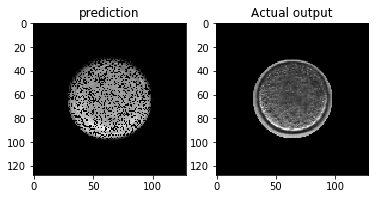

In [83]:
plt.figure()
plt.subplot(1,2,1)
plt.title("prediction")
plt.imshow(pred,cmap="gray")
plt.subplot(1,2,2)
plt.title("Actual output")
plt.imshow(output_img,cmap="gray")